In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

Available workers: 16


In [38]:
num_epochs = 35
batch_size = 64
batch_size_val = 64
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = ""#"sample"

train_df = pd.read_parquet('../data_created/mosq_train.parquet')
test_df = pd.read_parquet('../data_created/mosq_test.parquet')

transforms_list_train = [Bandpass(), RandomRoll() ,RandomFlip()]#, RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass()]


In [39]:
le = LabelEncoder()
train_df.iloc[:, 1] = le.fit_transform(train_df.iloc[:, 1])
X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)

test_df.iloc[:,1] = le.transform(test_df.iloc[:,1])
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

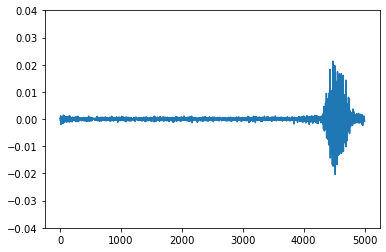

In [20]:
plot_wingbeat(train_dataset, idx=2)

In [21]:
outs = 6
if modeltype == 'conv1draw':
    model = Conv1dNetRAW(outputs=outs, dropout_p=.2)
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=outs))

class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(weight=torch.Tensor(weight).cuda())
elif outs > 1:
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [23]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)
        if outs == 1:
            y_batch = y_batch.type(torch.FloatTensor).cuda()
            correct_train += ((pred>0.5).int().squeeze() == y_batch.squeeze()).float().sum().item()
            loss = criterion(pred, y_batch.unsqueeze(1))
        else:
            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
            loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        pred = model(x_batch)
        if outs == 1:
            y_batch = y_batch.type(torch.FloatTensor).cuda()
            correct_valid += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
            val_loss = criterion(pred, y_batch.unsqueeze(1))
        else:
            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()
#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss),
        'val_loss': results['val_loss'].append(val_loss),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best)


Training..	:   0%|          | 0/2184 [00:00<?, ?it/s]

Train on gpu: True


Validating..	: 100%|██████████| 327/327 [02:13<00:00,  2.46it/s]


Epoch 0: train_acc: 71.6% loss: 0.9748032,  val_loss: 0.8501134 val_acc: 63.9%
Validation accuracy improved from 0.00 to 63.91. Saving model..


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 67.04it/s]


Epoch 1: train_acc: 77.9% loss: 0.6723859,  val_loss: 1.0059768 val_acc: 65.1%
Validation accuracy improved from 63.91 to 65.09. Saving model..


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 67.02it/s]


Epoch 2: train_acc: 79.9% loss: 0.5137612,  val_loss: 0.9147009 val_acc: 63.2%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.65it/s]


Epoch 3: train_acc: 81.4% loss: 1.0184245,  val_loss: 0.7433733 val_acc: 78.5%
Validation accuracy improved from 65.09 to 78.52. Saving model..


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.97it/s]


Epoch 4: train_acc: 82.5% loss: 0.4651643,  val_loss: 0.3559079 val_acc: 79.8%
Validation accuracy improved from 78.52 to 79.82. Saving model..


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.97it/s]


Epoch 5: train_acc: 83.5% loss: 0.2941866,  val_loss: 0.6993850 val_acc: 74.6%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 67.03it/s]


Epoch 6: train_acc: 84.1% loss: 0.3217630,  val_loss: 0.4384105 val_acc: 80.1%
Validation accuracy improved from 79.82 to 80.06. Saving model..


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.57it/s]


Epoch 7: train_acc: 84.7% loss: 0.2973251,  val_loss: 0.4437669 val_acc: 72.2%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.87it/s]


Epoch 8: train_acc: 85.3% loss: 0.3522678,  val_loss: 0.5937552 val_acc: 84.3%
Validation accuracy improved from 80.06 to 84.31. Saving model..


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.98it/s]


Epoch 9: train_acc: 85.8% loss: 0.4991016,  val_loss: 0.4398913 val_acc: 82.6%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.61it/s]


Epoch 10: train_acc: 86.2% loss: 0.3295687,  val_loss: 0.8757359 val_acc: 77.7%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.65it/s]


Epoch 11: train_acc: 86.5% loss: 0.1369659,  val_loss: 0.6384646 val_acc: 78.5%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.64it/s]


Epoch 12: train_acc: 86.9% loss: 0.2294680,  val_loss: 1.1700189 val_acc: 62.5%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.92it/s]


Epoch 13: train_acc: 87.3% loss: 0.5471618,  val_loss: 0.5418147 val_acc: 61.1%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.64it/s]


Epoch 14: train_acc: 87.5% loss: 0.4119644,  val_loss: 0.3638211 val_acc: 75.1%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.89it/s]


Epoch 15: train_acc: 87.9% loss: 0.6195370,  val_loss: 0.4863933 val_acc: 83.3%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.91it/s]


Epoch 16: train_acc: 88.1% loss: 0.7968314,  val_loss: 0.3303084 val_acc: 83.3%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.92it/s]


Epoch 17: train_acc: 88.5% loss: 0.1678981,  val_loss: 1.0286876 val_acc: 78.7%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.88it/s]


Epoch 18: train_acc: 88.7% loss: 0.0514618,  val_loss: 0.5457307 val_acc: 76.6%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.96it/s]


Epoch 19: train_acc: 88.8% loss: 0.2739582,  val_loss: 1.4072849 val_acc: 83.2%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.78it/s]


Epoch 20: train_acc: 89.1% loss: 0.1067008,  val_loss: 0.3265060 val_acc: 78.6%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.61it/s]


Epoch 21: train_acc: 89.3% loss: 0.2907554,  val_loss: 0.1131735 val_acc: 79.5%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.65it/s]


Epoch 22: train_acc: 89.4% loss: 0.1093718,  val_loss: 1.6873888 val_acc: 75.5%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.91it/s]


Epoch 23: train_acc: 89.7% loss: 0.6004006,  val_loss: 0.7780086 val_acc: 55.6%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.72it/s]


Epoch 24: train_acc: 89.9% loss: 0.0825595,  val_loss: 0.3292229 val_acc: 76.1%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.69it/s]


Epoch 25: train_acc: 90.2% loss: 0.4322518,  val_loss: 0.3452280 val_acc: 74.4%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.77it/s]


Epoch 26: train_acc: 90.5% loss: 0.2099203,  val_loss: 0.4054514 val_acc: 78.6%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.82it/s]


Epoch 27: train_acc: 90.5% loss: 0.2776303,  val_loss: 1.7408717 val_acc: 57.7%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.82it/s]


Epoch 28: train_acc: 90.8% loss: 0.1550690,  val_loss: 0.1622527 val_acc: 86.5%
Validation accuracy improved from 84.31 to 86.50. Saving model..


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.71it/s]


Epoch 29: train_acc: 91.0% loss: 0.1342526,  val_loss: 0.7413792 val_acc: 83.2%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.58it/s]


Epoch 30: train_acc: 91.2% loss: 0.1139297,  val_loss: 0.2918614 val_acc: 82.9%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.73it/s]


Epoch 31: train_acc: 91.2% loss: 0.3284256,  val_loss: 10.5878439 val_acc: 45.7%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 67.03it/s]


Epoch 32: train_acc: 91.5% loss: 0.1135694,  val_loss: 0.0808199 val_acc: 80.1%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.84it/s]


Epoch 33: train_acc: 91.5% loss: 0.2833518,  val_loss: 0.0892122 val_acc: 76.0%


Validating..	: 100%|██████████| 327/327 [00:04<00:00, 66.94it/s]


Epoch 34: train_acc: 91.7% loss: 0.2070235,  val_loss: 1.0273393 val_acc: 80.1%


# MORE LAYERS?

## Testing on test set

In [24]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/mosquito_model_best.pth.tar', model, optimizer)

In [40]:
model = model.to('cuda', dtype=torch.float)

_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 837/837 [06:02<00:00,  2.31it/s]

Accuracy: 86.47
Balanced accuracy: 86.25
Confusion matrix: 
[[0.85851278 0.07981625 0.00671835 0.01033592 0.03267298 0.01194373]
 [0.06736527 0.8754491  0.01976048 0.0257485  0.00808383 0.00359281]
 [0.01127425 0.0162559  0.84006293 0.10592554 0.01809124 0.00839014]
 [0.00841424 0.01067961 0.19708738 0.77055016 0.00819849 0.00507012]
 [0.03686781 0.02505121 0.01339215 0.00929573 0.9087758  0.0066173 ]
 [0.04674157 0.00247191 0.01273408 0.00434457 0.01220974 0.92149813]]


In [50]:
cm = np.array([[0.85851278, 0.07981625, 0.00671835, 0.01033592, 0.03267298, 0.01194373],
 [0.06736527, 0.8754491 , 0.01976048, 0.0257485 , 0.00808383, 0.00359281],
 [0.01127425, 0.0162559 , 0.84006293, 0.10592554, 0.01809124, 0.00839014],
 [0.00841424, 0.01067961, 0.19708738, 0.77055016, 0.00819849, 0.00507012],
 [0.03686781, 0.02505121, 0.01339215, 0.00929573, 0.9087758 , 0.0066173 ],
 [0.04674157, 0.00247191, 0.01273408, 0.00434457, 0.01220974, 0.92149813]])

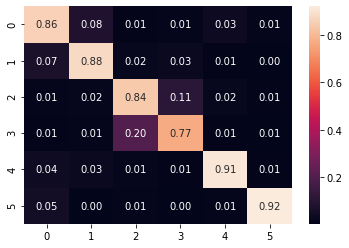

In [58]:
sns.heatmap(cm, annot=True, fmt='.2f');

In [41]:
def softmax_out(x):
    return np.argmax(F.softmax(x, dim=1), axis=1).tolist()[0]

In [43]:
# df_out = get_all_preds(model, test_dataloader, dataframe=True, binary=False)

In [44]:
# cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')
# sns.heatmap(cm, annot=True, fmt='.0%')
# plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");

In [45]:
# df_out.y.value_counts()#.value_counts()

# ------------------------------------------